# Instalación de Librerías y Configuración Inicial

En esta sección instalamos e importamos las librerías necesarias para el proyecto.  
Estas herramientas nos permiten:

- Cargar y manipular datos (`pandas`, `numpy`)
- Construir y evaluar modelos de machine learning (`scikit-learn`)
- Entrenar modelos avanzados de clasificación (`XGBoost`)
- Manejar desequilibrio en los datos (`SMOTE`)
- Guardar modelos entrenados (`joblib`)
- Generar visualizaciones (`matplotlib`, `seaborn`)


In [1]:
!pip install xgboost shap category_encoders optuna joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 32.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report, f1_score
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import shap
import joblib

# Carga de los Conjuntos de Datos

Cada enfermedad (Diabetes, Hipertensión y Obesidad) tiene su propio conjunto de datos dividido en:

- **X_train** → Características de entrenamiento
- **X_test** → Características de prueba
- **y_train** → Etiquetas reales de entrenamiento
- **y_test** → Etiquetas reales de prueba

Esto sigue la estructura de la fase de **Preparación de Datos** dentro de CRISP-DM.


In [3]:
candidates = {
    "diabetes": [
        "/content/drive/MyDrive/Semestre 11/Inteligencia de datos/Proyecto final/4_Cuarta fase/diabetes"
    ],
    "hypertension": [
        "/content/drive/MyDrive/Semestre 11/Inteligencia de datos/Proyecto final/4_Cuarta fase/hypertension"
    ],
    "obesity": [
        "/content/drive/MyDrive/Semestre 11/Inteligencia de datos/Proyecto final/4_Cuarta fase/obesidad"
    ]
}

In [4]:
def load_dataset(base_condition_path):
    X_train_path = os.path.join(base_condition_path, "X_train.csv")
    X_test_path = os.path.join(base_condition_path, "X_test.csv")
    y_train_path = os.path.join(base_condition_path, "y_train.csv")
    y_test_path = os.path.join(base_condition_path, "y_test.csv")

    X_train = pd.read_csv(X_train_path)
    X_test = pd.read_csv(X_test_path)
    y_train = pd.read_csv(y_train_path).squeeze()
    y_test = pd.read_csv(y_test_path).squeeze()

    return X_train, X_test, y_train, y_test

In [5]:
X_train_diab, X_test_diab, y_train_diab, y_test_diab = load_dataset(candidates["diabetes"][0])
X_train_hyp, X_test_hyp, y_train_hyp, y_test_hyp = load_dataset(candidates["hypertension"][0])
X_train_ob, X_test_ob, y_train_ob, y_test_ob = load_dataset(candidates["obesity"][0])

In [6]:
def fit_and_eval(X_train, y_train, X_test, y_test, name_prefix=''):
    results = {}
    # Original preprocessing removed as requested
    # pre = Pipeline([
    #     ('imputer', SimpleImputer(strategy='median')),
    #     ('scaler', StandardScaler())
    # ])
    # Xtr = pre.fit_transform(X_train)
    # Xte = pre.transform(X_test)

    # Using original data directly without imputation or scaling
    Xtr = X_train
    Xte = X_test

    # 1) Logistic Regression (baseline)
    lr = LogisticRegression(max_iter=5000)
    lr.fit(Xtr, y_train)
    y_pred_lr = lr.predict(Xte)
    y_proba_lr = lr.predict_proba(Xte)[:,1]
    results['logistic'] = {
        'model': lr,
        'accuracy': accuracy_score(y_test, y_pred_lr),
        'precision': precision_score(y_test, y_pred_lr, zero_division=0),
        'recall': recall_score(y_test, y_pred_lr, zero_division=0),
        'f1': f1_score(y_test, y_pred_lr, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_proba_lr),
        'y_pred': y_pred_lr,
        'y_proba': y_proba_lr
    }

    # 2) Decision Tree small
    dt = DecisionTreeClassifier(max_depth=4, random_state=42)
    dt.fit(Xtr, y_train)
    y_pred_dt = dt.predict(Xte)
    y_proba_dt = dt.predict_proba(Xte)[:,1]
    results['tree'] = {
        'model': dt,
        'accuracy': accuracy_score(y_test, y_pred_dt),
        'precision': precision_score(y_test, y_pred_dt, zero_division=0),
        'recall': recall_score(y_test, y_pred_dt, zero_division=0),
        'f1': f1_score(y_test, y_pred_dt, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_proba_dt),
        'y_pred': y_pred_dt,
        'y_proba': y_proba_dt
    }

    # 3) XGBoost (tu modelo)
    xgb = XGBClassifier(
        n_estimators=150, learning_rate=0.07, max_depth=2,
        subsample=0.5, colsample_bytree=0.5, reg_alpha=3, reg_lambda=8,
        min_child_weight=6, use_label_encoder=False, eval_metric='logloss', verbosity=0
    )
    xgb.fit(Xtr, y_train)
    y_pred_x = xgb.predict(Xte)
    y_proba_x = xgb.predict_proba(Xte)[:,1]
    results['xgb'] = {
        'model': xgb,
        'accuracy': accuracy_score(y_test, y_pred_x),
        'precision': precision_score(y_test, y_pred_x, zero_division=0),
        'recall': recall_score(y_test, y_pred_x, zero_division=0),
        'f1': f1_score(y_test, y_pred_x, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_proba_x),
        'y_pred': y_pred_x,
        'y_proba': y_proba_x
    }

    # Return preprocessor as None since it's removed
    return results, None

In [7]:
# Run for each disease (example for hypertension)
results_hyp, pre_hyp = fit_and_eval(X_train_hyp, y_train_hyp, X_test_hyp, y_test_hyp, 'hypertension')
results_diab, pre_diab = fit_and_eval(X_train_diab, y_train_diab, X_test_diab, y_test_diab, 'diabetes')
results_ob, pre_ob = fit_and_eval(X_train_ob, y_train_ob, X_test_ob, y_test_ob, 'obesity')

In [8]:
# Show summary table function
def summary_table(results):
    rows = []
    for name, r in results.items():
        rows.append([name, r['accuracy'], r['precision'], r['recall'], r['f1'], r['roc_auc']])
    return pd.DataFrame(rows, columns=['model','accuracy','precision','recall','f1','roc_auc']).set_index('model')

print("Hypertension:")
print(summary_table(results_hyp))
print("\nDiabetes:")
print(summary_table(results_diab))
print("\nObesity:")
print(summary_table(results_ob))

Hypertension:
          accuracy  precision    recall        f1   roc_auc
model                                                      
logistic  0.857093   0.815537  0.922942  0.865922  0.921078
tree      0.874781   0.858579  0.897373  0.877548  0.940091
xgb       0.926270   0.905396  0.952014  0.928120  0.976092

Diabetes:
          accuracy  precision    recall        f1   roc_auc
model                                                      
logistic  0.735317   0.735576  0.769162  0.751994  0.807117
tree      0.713215   0.710940  0.758832  0.734106  0.776089
xgb       0.739613   0.733529  0.786677  0.759174  0.811170

Obesity:
          accuracy  precision    recall        f1   roc_auc
model                                                      
logistic  0.971098   0.977370  0.983174  0.980263  0.994137
tree      0.964836   0.977175  0.974596  0.975884  0.990196
xgb       0.969412   0.977632  0.980534  0.979081  0.993713


In [9]:
# McNemar (requires statsmodels)
!pip install statsmodels
from statsmodels.stats.contingency_tables import mcnemar

def mcnemar_test(y_true, y_pred_a, y_pred_b):
    # build contingency table
    a_correct = (y_pred_a == y_true)
    b_correct = (y_pred_b == y_true)
    # table:
    #           b_correct
    # a_correct   True  False
    # True
    # False
    table = np.zeros((2,2), dtype=int)
    table[1,1] = np.sum((a_correct==True) & (b_correct==True))
    table[1,0] = np.sum((a_correct==True) & (b_correct==False))
    table[0,1] = np.sum((a_correct==False) & (b_correct==True))
    table[0,0] = np.sum((a_correct==False) & (b_correct==False))
    # Use exact if small counts
    res = mcnemar(table, exact=False)
    return table, res.statistic, res.pvalue

# Example: compare xgb vs logistic on hypertension
table, stat, p = mcnemar_test(y_test_hyp.values, results_hyp['xgb']['y_pred'], results_hyp['logistic']['y_pred'])
print('Contingency table:\n', table)
print('Statistic:', stat, 'p-value:', p)

Contingency table:
 [[ 310  111]
 [ 506 4783]]
Statistic: 251.59805510534846 p-value: 1.1642697329757235e-56


In [10]:
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample

def bootstrap_auc_diff(y_true, proba_a, proba_b, n_boot=1000, seed=42):
    rng = np.random.RandomState(seed)
    diffs = []
    n = len(y_true)
    for i in range(n_boot):
        idx = rng.randint(0, n, n)
        a = roc_auc_score(y_true[idx], proba_a[idx])
        b = roc_auc_score(y_true[idx], proba_b[idx])
        diffs.append(a-b)
    diffs = np.array(diffs)
    ci_low, ci_high = np.percentile(diffs, [2.5, 97.5])
    return diffs.mean(), (ci_low, ci_high)

# Example
mean_diff, ci = bootstrap_auc_diff(y_test_hyp.values, results_hyp['xgb']['y_proba'], results_hyp['logistic']['y_proba'])
print("Mean AUC diff (xgb - log):", mean_diff, "95% CI:", ci)


Mean AUC diff (xgb - log): 0.0549661971534931 95% CI: (np.float64(0.04990395510023609), np.float64(0.060718458391327876))


# Entrenamiento de Modelos (XGBoost)

Se entrena un modelo **XGBoost** para cada enfermedad, ya que:

- Funciona bien con datos tabulares
- Maneja relaciones no lineales
- Incluye regularización → evita sobreajuste
- Permite interpretar importancia de variables

Los hiperparámetros fueron ajustados para lograr un equilibrio entre:
- Precisión
- Generalización
- Robustez


In [11]:
def train_and_evaluate(X_train, X_test, y_train, y_test, disease_name):

    model = Pipeline([
        ("clf", XGBClassifier(
            n_estimators=150,
            learning_rate=0.07,
            max_depth=2,
            subsample=0.5,
            colsample_bytree=0.5,
            reg_alpha=3,
            reg_lambda=8,
            eval_metric="logloss",
            min_child_weight=6,
            base_score=0.5 # Explicitly set base_score to a float
        ))
    ])

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"=== Resultados para {disease_name.upper()} ===")
    print(classification_report(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_proba))

    joblib.dump(model, f"{disease_name}_model.joblib")

    return model, y_proba

In [12]:
model_diab, prob_diab = train_and_evaluate(X_train_diab, X_test_diab, y_train_diab, y_test_diab, "diabetes")
model_hyp, prob_hyp = train_and_evaluate(X_train_hyp, X_test_hyp, y_train_hyp, y_test_hyp, "hypertension")
model_ob, prob_ob = train_and_evaluate(X_train_ob, X_test_ob, y_train_ob, y_test_ob, "obesity")

=== Resultados para DIABETES ===
              precision    recall  f1-score   support

         0.0       0.75      0.69      0.72      6124
         1.0       0.73      0.79      0.76      6680

    accuracy                           0.74     12804
   macro avg       0.74      0.74      0.74     12804
weighted avg       0.74      0.74      0.74     12804

ROC AUC: 0.8111215884690449
=== Resultados para HYPERTENSION ===
              precision    recall  f1-score   support

           0       0.95      0.90      0.92      2855
           1       0.91      0.95      0.93      2855

    accuracy                           0.93      5710
   macro avg       0.93      0.93      0.93      5710
weighted avg       0.93      0.93      0.93      5710

ROC AUC: 0.9760920865780685
=== Resultados para OBESITY ===
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      1121
           1       0.98      0.98      0.98      3031

    accuracy            

# Guardado de Modelos y Probabilidades

Cada modelo entrenado se guarda en formato `.joblib`, lo que permite:
- Reutilizar el modelo sin necesidad de re-entrenarlo
- Integrarlo en aplicaciones o APIs

También se exportan probabilidades de predicción:
- Útiles para interpretación clínica
- Permiten análisis de riesgo personalizado


In [13]:
df_probs_diab = pd.DataFrame({
    "prob_diabetes": prob_diab
})
df_probs_diab.to_csv("probabilities_diabetes.csv", index=False)
print("Diabetes Probabilities:")
print(df_probs_diab.head())

df_probs_hyp = pd.DataFrame({
    "prob_hypertension": prob_hyp
})
df_probs_hyp.to_csv("probabilities_hypertension.csv", index=False)
print("\nHypertension Probabilities:")
print(df_probs_hyp.head())

df_probs_ob = pd.DataFrame({
    "prob_obesity": prob_ob
})
df_probs_ob.to_csv("probabilities_obesity.csv", index=False)
print("\nObesity Probabilities:")
print(df_probs_ob.head())

Diabetes Probabilities:
   prob_diabetes
0       0.045388
1       0.754089
2       0.398857
3       0.539901
4       0.915508

Hypertension Probabilities:
   prob_hypertension
0           0.814312
1           0.912064
2           0.538466
3           0.518497
4           0.972066

Obesity Probabilities:
   prob_obesity
0      0.997818
1      0.036498
2      0.403100
3      0.009042
4      0.004445


# Evaluación del Modelo con Métricas Interpretables

Además de precisión y F1-score, calculamos métricas más comprensibles:

| Métrica | Interpretación |
|--------|---------------|
| **Sensibilidad (Recall)** | Capacidad de detectar pacientes enfermos |
| **Especificidad** | Capacidad de identificar pacientes sanos |
| **Precisión (Precision)** | Qué tan confiables son los positivos |
| **Accuracy** | Porcentaje total de aciertos |

También se muestra la **Matriz de Confusión**, que permite visualizar:
- Verdaderos Positivos (TP)
- Falsos Positivos (FP)
- Falsos Negativos (FN)
- Verdaderos Negativos (TN)

Esto facilita explicar resultados a personal médico.


In [14]:
from sklearn.metrics import confusion_matrix

def evaluar_metricas_faciles(y_test, y_pred, disease_name):
    cm = confusion_matrix(y_test, y_pred)

    TN, FP, FN, TP = cm.ravel()

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    sensitivity = TP / (TP + FN)   # Recall / TPR
    specificity = TN / (TN + FP)   # True Negative Rate
    precision = TP / (TP + FP)

    print(f"\nMÉTRICAS SIMPLES — {disease_name.upper()}")
    print("------------------------------------------")
    print(f"Exactitud (Accuracy):     {accuracy:.3f}")
    print(f"Sensibilidad (Recall):   {sensitivity:.3f}  → Capacidad de detectar enfermos")
    print(f"Especificidad:           {specificity:.3f}  → Capacidad de detectar sanos")
    print(f"Precisión (Precision):   {precision:.3f}")
    print("\nMATRIZ DE CONFUSIÓN")
    print(cm)


In [15]:
import seaborn as sns

def plot_conf_matrix(y_test, y_pred, disease_name):
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matriz de Confusión — {disease_name.capitalize()}")
    plt.xlabel("Predicción")
    plt.ylabel("Valor Real")
    plt.show()



MÉTRICAS SIMPLES — DIABETES
------------------------------------------
Exactitud (Accuracy):     0.739
Sensibilidad (Recall):   0.785  → Capacidad de detectar enfermos
Especificidad:           0.689  → Capacidad de detectar sanos
Precisión (Precision):   0.734

MATRIZ DE CONFUSIÓN
[[4219 1905]
 [1433 5247]]


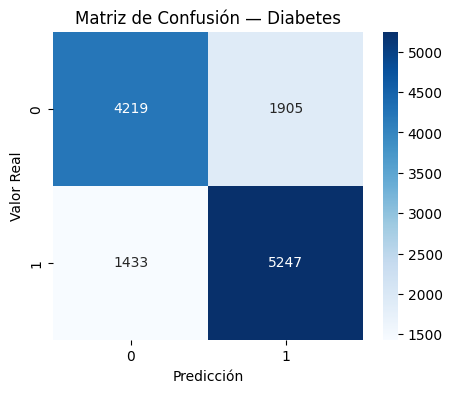


MÉTRICAS SIMPLES — HIPERTENSIÓN
------------------------------------------
Exactitud (Accuracy):     0.926
Sensibilidad (Recall):   0.952  → Capacidad de detectar enfermos
Especificidad:           0.901  → Capacidad de detectar sanos
Precisión (Precision):   0.905

MATRIZ DE CONFUSIÓN
[[2571  284]
 [ 137 2718]]


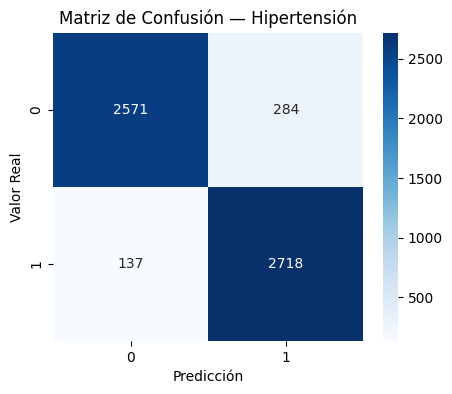


MÉTRICAS SIMPLES — OBESIDAD
------------------------------------------
Exactitud (Accuracy):     0.970
Sensibilidad (Recall):   0.982  → Capacidad de detectar enfermos
Especificidad:           0.939  → Capacidad de detectar sanos
Precisión (Precision):   0.978

MATRIZ DE CONFUSIÓN
[[1053   68]
 [  56 2975]]


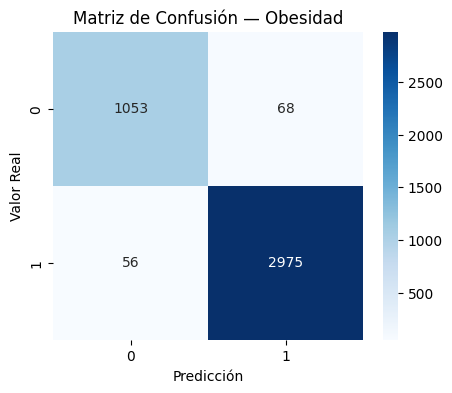

In [16]:
# Diabetes
y_pred_diab = model_diab.predict(X_test_diab)
evaluar_metricas_faciles(y_test_diab, y_pred_diab, "diabetes")
plot_conf_matrix(y_test_diab, y_pred_diab, "diabetes")

# Hipertensión
y_pred_hyp = model_hyp.predict(X_test_hyp)
evaluar_metricas_faciles(y_test_hyp, y_pred_hyp, "hipertensión")
plot_conf_matrix(y_test_hyp, y_pred_hyp, "hipertensión")

# Obesidad
y_pred_ob = model_ob.predict(X_test_ob)
evaluar_metricas_faciles(y_test_ob, y_pred_ob, "obesidad")
plot_conf_matrix(y_test_ob, y_pred_ob, "obesidad")


In [17]:
def expected_cost(cm, C_FN=1500, C_FP=100):
    tn, fp, fn, tp = cm.ravel()
    total = tn+fp+fn+tp
    return (fn*C_FN + fp*C_FP)/total

def choose_threshold_by_cost(y_true, y_proba, C_FN=1500, C_FP=100):
    best = (None, float('inf'))
    for t in np.linspace(0.01, 0.99, 99):
        yp = (y_proba >= t).astype(int)
        cm = confusion_matrix(y_true, yp)
        cost = expected_cost(cm, C_FN=C_FN, C_FP=C_FP)
        if cost < best[1]:
            best = (t, cost)
    return best

# Example choose for diabetes:
t_diab, cost_diab = choose_threshold_by_cost(y_test_diab.values, results_diab['xgb']['y_proba'], C_FN=2000, C_FP=100)
print("Best threshold diabetes by cost:", t_diab, "expected cost:", cost_diab)


Best threshold diabetes by cost: 0.05 expected cost: 45.7357075913777


In [18]:
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
# calibration curve
prob_true, prob_pred = calibration_curve(y_test_diab, results_diab['xgb']['y_proba'], n_bins=10)
# Brier
from sklearn.metrics import brier_score_loss
print("Brier diabetes:", brier_score_loss(y_test_diab, results_diab['xgb']['y_proba']))


Brier diabetes: 0.1758945753222496
